In [1]:
import pandas as pd
import yfinance as yf
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

In [2]:
# Get the list of S&P 500 constituents
sp500_tickers = pd.read_excel(
    "https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx",
    header=4).Ticker.dropna().to_list()

# Retrieve historical data
df = yf.download(sp500_tickers, period='10y')
sp500 = df['Adj Close'].dropna(how='all', axis=1)

[*********************100%%**********************]  504 of 504 completed


3 Failed downloads:
['BRK.B', '-']: Exception('%ticker%: No data found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=10y)')


In [3]:
sp500.tail(1) #Adjusted Close

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-21 00:00:00,138.940002,14.35,194.679993,152.589996,142.089996,108.480003,74.160004,348.75,600.140015,196.279999,...,90.720001,61.529999,101.730003,35.189999,111.690002,129.979996,119.650002,265.309998,43.619999,194.660004


In [4]:
# Define the time period and lag, can be changed to any number and code will work
time_period = 1260  # 5 years
lag = 20 # lag of 20 days


## Momentum Factors:
 ### Parameter for calculation is used for the backtest. The backtest will run 5 years but can be changed as long as there is sufficient data downloaded.

In [5]:
#how_many_days_back = 0 for current, 1260 for 5 years. It's for backtesting.

def calculate_momentum_factors(how_many_days_back):
# Define the start and end points for the data slice
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    
    lagged_closed_price = sp500[-start_time: -most_current_time ] #slice the dataframe to get 5 years
    rolling_mean_price = lagged_closed_price.rolling(window= time_period-251).mean().dropna(how='all') # get the rolling mean price window for 1 year

    # Calculate the 52-week trend
    slope_info = pd.DataFrame(index=sp500.columns)
    for i in range(1, lag + 1): 
        slope_info[i] = rolling_mean_price.apply(
            lambda x: np.polyfit(
                np.arange(len(x[-i - 252: -i])),
                                  x[-i - 252: -i], 1)[0] if x[-i - 252: -i].notna().all() else np.nan) 
    
    _52_week_trend = slope_info.mean(axis=1) 


    # x - x.min() / x.min() * 100 where x is the adjusted close price of our 500 stocks during the stored slice of time period
    percent_above_260 = (lagged_closed_price - lagged_closed_price.rolling(window=260).min()) / lagged_closed_price.rolling(window=260).min() * 100
    percent_above_260 = percent_above_260.dropna(how='all').mean()

    # Rolling 4 week mean - rolling 52 week mean / rolling 52 week mean * 100
    oscillator = (lagged_closed_price.rolling(window=4*5).mean() - lagged_closed_price.rolling(window=52*5).mean()) / lagged_closed_price.rolling(window=52*5).mean() * 100
    oscillator = oscillator.dropna(how='all').mean()    

    # percent change of the adjusted close price over 39 weeks
    returns_39w = lagged_closed_price.pct_change(periods= 39 * 5).dropna(how='all').mean() 
    

    # 51 week Volume Price Trend
    volume = df['Volume'].dropna(how='all', axis=1)[-lag - time_period: -lag]
    vpt = (volume * lagged_closed_price.pct_change()).cumsum() # volume price trend is the cumulative sum of volume * pct_change 
    vpt_51w = (vpt - vpt.shift(periods=51 * 5)).dropna(how='all').mean()
    # the shift is used to shift the df by 51 weeks so that we can calculate the difference between the current and prior 51 week period 
    

    # Creating the DataFrame
    new_table = pd.DataFrame(index=sp500.transpose().index)
    new_table['Slope 52 Week Trend-Line'] = _52_week_trend
    new_table['Percent above 260 Day Low'] = percent_above_260
    new_table['4/52 Week Oscillator'] = oscillator
    new_table['39_Week_Return'] = returns_39w
    new_table['51 Week Volume Price Trend'] = vpt_51w
    return new_table

## Momentum factors (5 years prior to current date) (20 day lag)

Aggregate factors with z-score calculation. Z-scores will determine the long basket and short basket.

In [19]:
momentum_factors = calculate_momentum_factors(0)
momentum_factors

,Slope 52 Week Trend-Line,Percent above 260 Day Low,4/52 Week Oscillator,39_Week_Return,51 Week Volume Price Trend
A,0.057624,38.283549,6.965620,0.134882,6.111663e+04
AAL,-0.016173,44.087919,-7.012189,-0.051252,9.197480e+07
AAPL,0.121117,60.408543,15.815833,0.315956,3.206389e+07
ABBV,0.082578,40.274723,10.637098,0.176332,-1.362297e+06
ABNB,NaN,32.728516,-6.099047,-0.047180,1.309394e+06
...,...,...,...,...,...
YUM,0.034269,36.471937,3.349701,0.079107,3.971762e+04
ZBH,0.013415,34.784576,0.482974,0.040251,-5.460017e+04
ZBRA,0.083385,57.654745,4.668187,0.147962,-1.096047e+05
ZION,-0.005094,52.797257,-0.812022,0.031514,-1.404984e+06


In [35]:
# Path
excel_file_path = 'resources/momentum_factors.xlsx'

# Save the DataFrame to Excel
momentum_factors.to_excel(excel_file_path, index=True)

In [48]:
def calculate_z_scores(x): # where x is equal to momentum_factors
    z_scores = (x - x.mean()) / x.std() # standard z score formula
    z_scores = z_scores.sum(axis=1) # summing the z-scores of each factor to get the total z-score per asset
    # The z-score is the number of standard deviations away from the mean a data point is.
    return z_scores.sort_values(ascending=False) # sorts the z-scores in descending order

long_basket = calculate_z_scores(momentum_factors)[:10] # selects the top 10 z-scores
short_basket = calculate_z_scores(momentum_factors)[-10:] # selects the bottom 10 z-scores

# basket_df = pd.DataFrame({'Long Basket': long_basket, 'Short Basket': short_basket})

# # Display the DataFrame
# print(basket_df)

print("Long Basket:")
print(long_basket)
print("\nShort Basket:")
print(short_basket)

def get_lagged_closed_price(how_many_days_back):
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    # Calculate the rolling mean price
    lagged_closed_price = sp500[-start_time: -most_current_time ]
    return lagged_closed_price

lagged_closed_price = get_lagged_closed_price(0)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price = lagged_closed_price[long_basket.index]
short_lagged_closed_price = lagged_closed_price[short_basket.index]

Long Basket:
TSLA    41.853053
MRNA    19.958463
ENPH    18.639957
NVDA    16.483369
NVR     15.532209
AZO      9.813193
BLDR     9.777899
CMG      9.517172
AMD      9.423302
FCX      8.322494
dtype: float64

Short Basket:
VZ     -5.231514
BXP    -5.331128
INTC   -5.332256
PARA   -5.372274
WBA    -5.381634
WBD    -5.820464
BAX    -6.003801
FIS    -6.193288
VTRS   -6.390118
VFC    -7.572688
dtype: float64


## Creating the Back-Tested Baskets

In [49]:
# First get the momentum factors
momentum_factors_past_5y = calculate_momentum_factors(1260) # 5 years
# Then get the z-scores
long_basket_past_5y = calculate_z_scores(momentum_factors_past_5y)[:10] # selects the top 10 z-scores
short_basket_past_5y =  calculate_z_scores(momentum_factors_past_5y)[-10:] # selects the top 10 z-scores


print("Long Basket Past 5 Years:")
print (long_basket_past_5y)
print("Short Basket Past 5 Years:")
print(short_basket_past_5y)


lagged_closed_price_past_5y = get_lagged_closed_price(1260)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[long_basket_past_5y.index]
short_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[short_basket_past_5y.index]


Exception ignored in: <function ZipFile.__del__ at 0x7fc77230a430>
Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/lib/python3.8/zipfile.py", line 1821, in __del__
    self.close()
  File "/Users/alex/opt/anaconda3/lib/python3.8/zipfile.py", line 1838, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


Long Basket Past 5 Years:
NVR     19.754673
NVDA    17.604150
AMD     14.687047
CZR     13.944239
ETSY    12.328808
NFLX    11.929909
PAYC    11.205550
ALGN    11.182162
TTWO     8.389273
AXON     8.238379
dtype: float64
Short Basket Past 5 Years:
WBD   -4.953315
F     -5.001953
MCK   -5.133396
HWM   -5.175836
BEN   -5.254403
SLB   -5.449470
APA   -5.619225
CMG   -5.869408
GE    -6.322668
EQT   -6.485358
dtype: float64


## Cumulative Returns

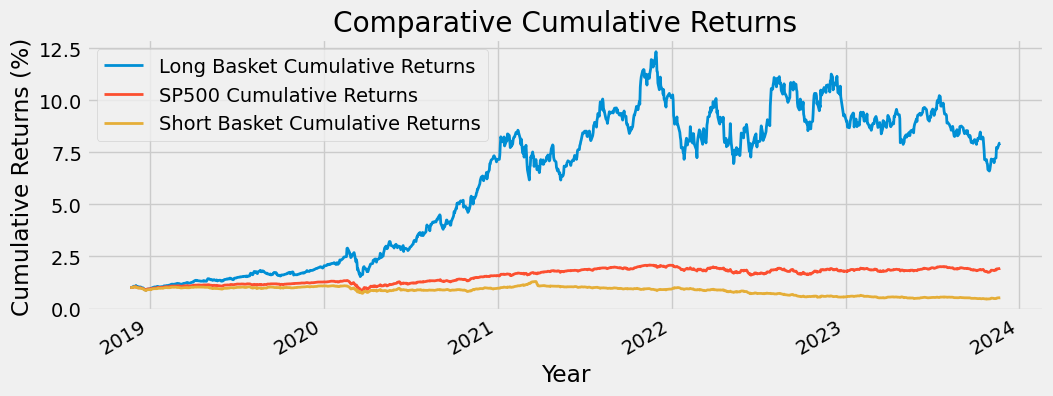

In [50]:
def calculate_cumulative_returns(dataf): 
    returns = dataf.pct_change()
    cumulative_returns = (1 + returns).cumprod().mean(axis=1) 
    return cumulative_returns

# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns = calculate_cumulative_returns(lagged_closed_price)
long_cumulative_returns = calculate_cumulative_returns(long_lagged_closed_price)
short_cumulative_returns = calculate_cumulative_returns(short_lagged_closed_price)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns.plot(label='Long Basket Cumulative Returns', lw=2) # lw is line width
cumulative_returns.plot(label='SP500 Cumulative Returns', lw =2)
short_cumulative_returns.plot(label='Short Basket Cumulative Returns', lw=2)

plt.legend()
plt.title('Comparative Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

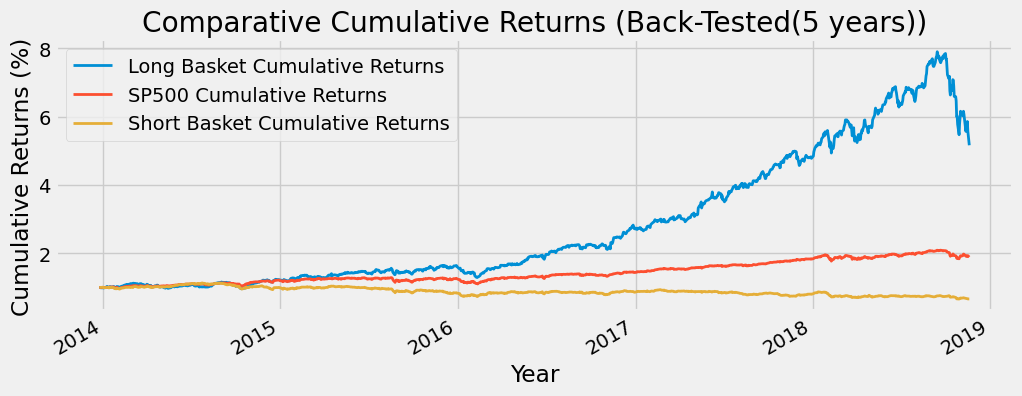

In [51]:
# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns_past_5y = calculate_cumulative_returns(lagged_closed_price_past_5y)
long_cumulative_returns_past_5y = calculate_cumulative_returns(long_lagged_closed_price_past_5y)
short_cumulative_returns_past_5y = calculate_cumulative_returns(short_lagged_closed_price_past_5y)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns_past_5y.plot(label='Long Basket Cumulative Returns', lw=2) # lw is line width
cumulative_returns_past_5y.plot(label='SP500 Cumulative Returns', lw =2)
short_cumulative_returns_past_5y.plot(label='Short Basket Cumulative Returns', lw=2)

plt.legend()
plt.title('Comparative Cumulative Returns (Back-Tested(5 years))')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

## Monthly Potfolio Return Bar Charts (Pos/Neg coloring) vs SP500

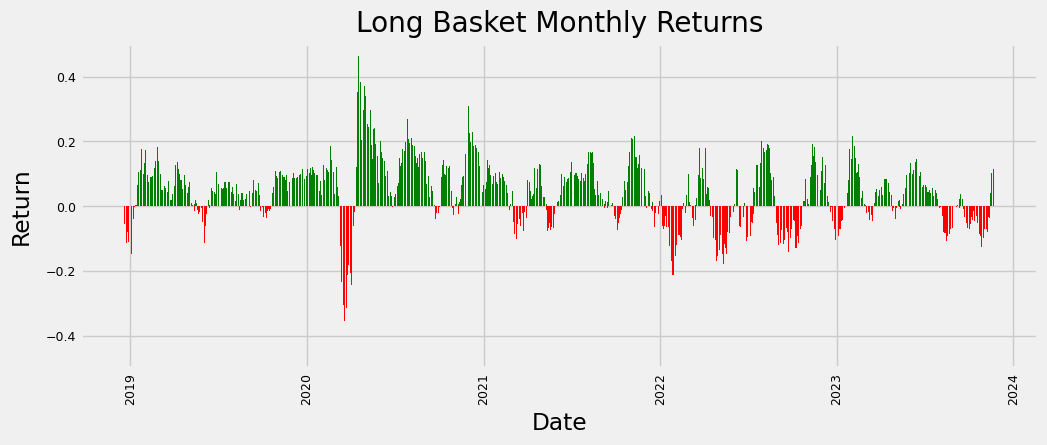

In [52]:
# Calculate 20-day returns, take the mean, drop NaNs
long_monthly_returns = long_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = long_monthly_returns.index
ydata = long_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in long_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Long Basket Monthly Returns', pad=9)
plt.show()

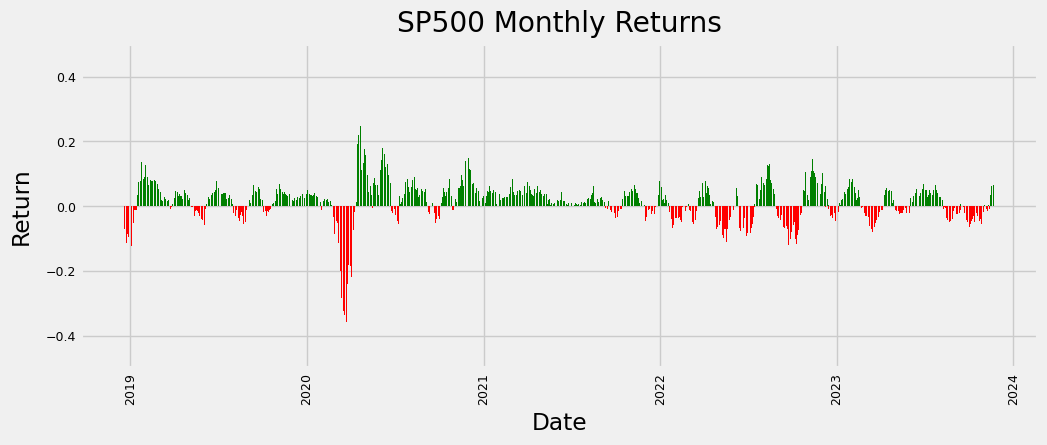

In [53]:
# Calculate 20-day returns, take the mean, drop NaNs
monthly_returns = lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = monthly_returns.index
ydata = monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('SP500 Monthly Returns', pad=9)
plt.show()

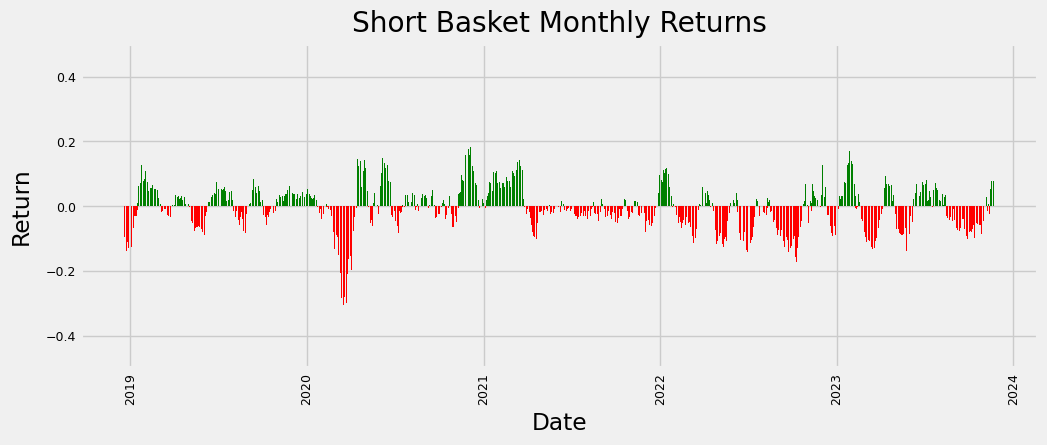

In [54]:
# Calculate 20-day returns, take the mean, drop NaNs
short_monthly_returns = short_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = short_monthly_returns.index
ydata = short_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in short_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Short Basket Monthly Returns', pad=9)
plt.show()

## Monthly return for long picks vs short picks vs SP500

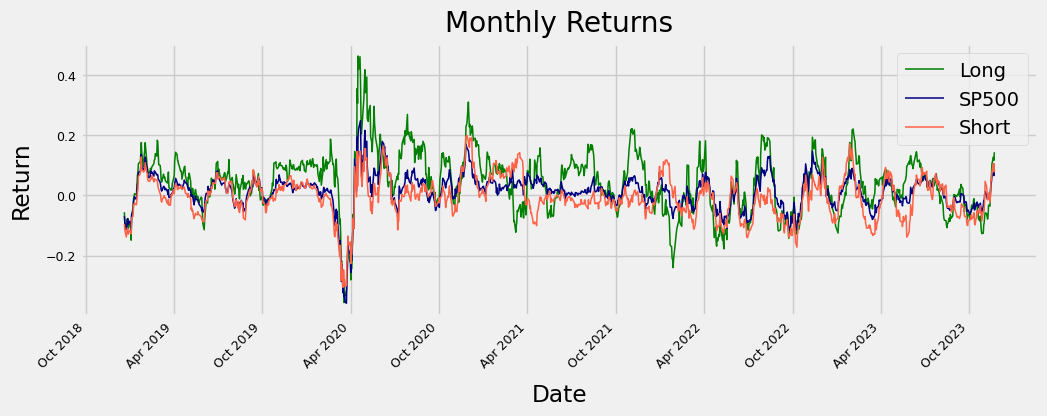

In [55]:
# Three plots 
plt.style.use('fivethirtyeight')
long_monthly_returns.plot(figsize=(11,4), label = 'Long', color = 'g', lw=1.1)
monthly_returns.plot(figsize=(11,4), label = 'SP500', color ='navy', lw = 1.1)
short_monthly_returns.plot(figsize=(11,4),label= 'Short', color = 'tomato', lw=1.1)

# Plot configurations 
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y',))
plt.xticks(rotation=45)
plt.tick_params(axis='both', labelsize=9)
plt.ylabel('Return',labelpad=9)
plt.xlabel('Date',labelpad=9)
plt.title('Monthly Returns',pad=9)
plt.show()

# Extra Credit : Portfolio weights
## Imported class from Efficient Frontier 

In [60]:
%%capture 
# ^ this is used to suppress the output of the cell
import sys

# Add the directory containing the module to the Python path
#sys.path.insert(0, '/Users/jcarlito/Documents/GitHub/Quantative-Finance-Repo/EF')
sys.path.insert(0, '/Quantative-Finance-Repo/EF')

from Efficient_Frontier import EfficientFrontier

In [61]:
ef = EfficientFrontier(sp500[long_basket.index])
ef.calculate_portfolio() #Printing Annual Returns

TSLA    1.479462
MRNA    1.586385
ENPH    1.640243
NVDA    1.590819
NVR     1.237480
AZO     1.202315
BLDR    1.442931
CMG     1.204962
AMD     1.523527
FCX     1.174869
dtype: float64


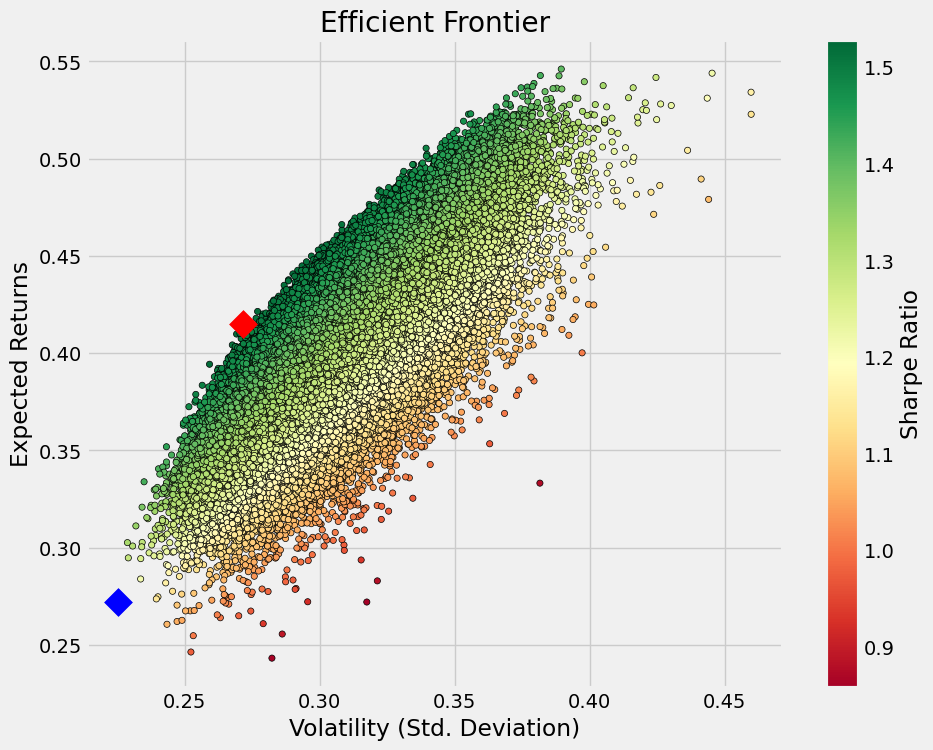

In [62]:
ef.plot_frontier()

In [63]:
ef.get_optimal_portfolio()

              Minimum Risk Adjusted Values  Max Risk Adjusted Values
Returns                           0.272059                  0.415214
Volatility                        0.225386                  0.271621
Sharpe Ratio                      1.207083                  1.528651
TSLA Weight                       0.007417                  0.075785
MRNA Weight                       0.041868                  0.111688
ENPH Weight                       0.001955                  0.081093
NVDA Weight                       0.045121                  0.221835
NVR Weight                        0.273706                  0.141106
AZO Weight                        0.272002                  0.216795
BLDR Weight                       0.038970                  0.078451
CMG Weight                        0.193547                  0.061169
AMD Weight                        0.049188                  0.010421
FCX Weight                        0.076225                  0.001657
